In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import tensorflow as tf
import tensorflow_probability as tfp

from tf_keras.layers import Input, Dense, Concatenate
from tf_keras.models import Model
from tf_keras.optimizers.legacy import Adam

tfd = tfp.distributions
tfb = tfp.bijectors
print("TFP Version", tfp.__version__)
print("TF  Version",tf.__version__)

TFP Version 0.25.0
TF  Version 2.18.0


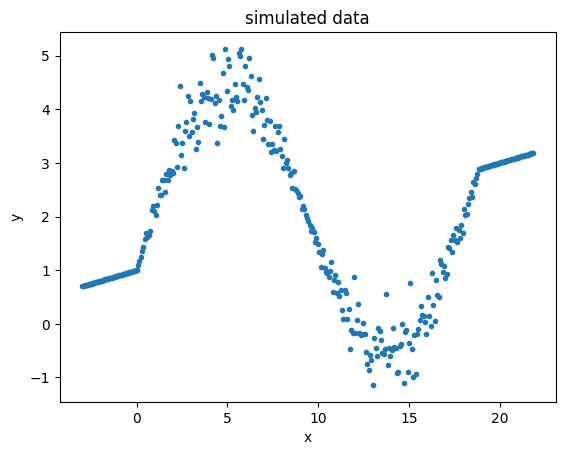

In [2]:
def create_sine_data(n = 2048):
    np.random.seed(32)
    x = np.linspace(0,1*2*np.pi,n)
    y1 = 3*np.sin(x)
    y1 = np.concatenate((np.zeros(60), y1+np.random.normal(0,0.15*np.abs(y1),n),np.zeros(60)))
    x=np.concatenate((np.linspace(-3,0,60),np.linspace(0,3*2*np.pi,n),np.linspace(3*2*np.pi,3*2*np.pi+3,60)))
    y2 = 0.1*x+1
    y=y1+y2
    return x,y

## use custom function to simulate some data 
x,y = create_sine_data(256) # Note that the model has been trained with 2048 data points
plt.scatter(x=x,y=y,marker='.',alpha=1)
plt.title("simulated data")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [3]:
def NLL(y, distr): 
  return -distr.log_prob(y) 

def normal_sp(params): 
  return tfd.Normal(loc=params[:,0:1], scale=1e-3 + tf.math.softplus(0.05 * params[:,1:2]))# both parameters are learnable

In [4]:
kernel_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (x.shape[0] * 1.0)
bias_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (x.shape[0] * 1.0)


inputs = Input(shape=(1,))


hidden = tfp.layers.DenseFlipout(20,bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn,activation="relu")(inputs)
hidden = tfp.layers.DenseFlipout(50,bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn,activation="relu")(hidden)
hidden = tfp.layers.DenseFlipout(20,bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn,activation="relu")(hidden)
params = tfp.layers.DenseFlipout(2,bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn)(hidden)
dist = tfp.layers.DistributionLambda(normal_sp)(params) 


model_vi = Model(inputs=inputs, outputs=dist)
model_vi.compile(Adam(learning_rate=0.0005), loss=NLL) 

/Users/fazaghifari/miniconda3/envs/tfprobenv/lib/python3.9/site-packages/tensorflow_probability/python/layers/util.py:99: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/Users/fazaghifari/miniconda3/envs/tfprobenv/lib/python3.9/site-packages/tensorflow_probability/python/layers/util.py:109: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(
/Users/fazaghifari/miniconda3/envs/tfprobenv/lib/python3.9/site-packages/tf_keras/src/initializers/initializers.py:121: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than

In [5]:
model_vi.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense_flipout (DenseFlipou  (None, 20)                80        
 t)                                                              
                                                                 
 dense_flipout_1 (DenseFlip  (None, 50)                2100      
 out)                                                            
                                                                 
 dense_flipout_2 (DenseFlip  (None, 20)                2040      
 out)                                                            
                                                                 
 dense_flipout_3 (DenseFlip  (None, 2)                 84        
 out)                                                        

Epoch 1/10000
1/1 [==============================] - 1s 982ms/step - loss: 21.2766
Epoch 2/10000
1/1 [==============================] - 0s 3ms/step - loss: 20.6271
Epoch 3/10000
1/1 [==============================] - 0s 4ms/step - loss: 21.0869
Epoch 4/10000
1/1 [==============================] - 0s 4ms/step - loss: 21.0677
Epoch 5/10000
1/1 [==============================] - 0s 3ms/step - loss: 21.0843
Epoch 6/10000
1/1 [==============================] - 0s 3ms/step - loss: 21.1162
Epoch 7/10000
1/1 [==============================] - 0s 3ms/step - loss: 21.3796
Epoch 8/10000
1/1 [==============================] - 0s 3ms/step - loss: 20.9446
Epoch 9/10000
1/1 [==============================] - 0s 3ms/step - loss: 20.8802
Epoch 10/10000
1/1 [==============================] - 0s 3ms/step - loss: 21.2072
Epoch 11/10000
1/1 [==============================] - 0s 2ms/step - loss: 21.0566
Epoch 12/10000
1/1 [==============================] - 0s 3ms/step - loss: 20.9270
Epoch 13/10000
1/1 [===

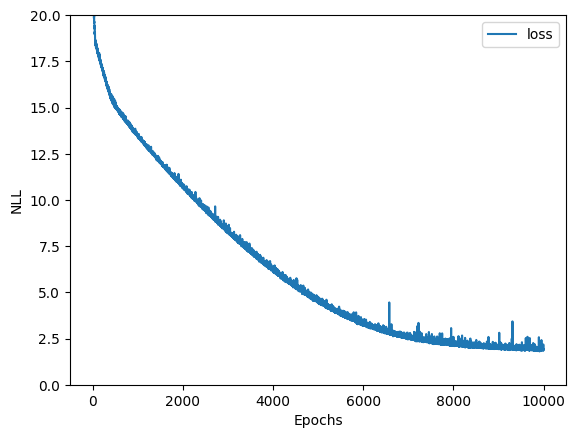

In [6]:
from time import time
start = time()
# Note that the model has been trained with 2048 data points

history = model_vi.fit(x, y, epochs=10000, verbose=1,batch_size=512)
print('time taken : ',np.round(time() - start,3)) #468 sec
model_vi.save_weights('model_vi.hdf5')
plt.plot(history.history['loss'])
plt.legend(['loss'])
plt.ylabel('NLL')
plt.xlabel('Epochs')
plt.ylim([0,20])
plt.show()

100%|██████████| 200/200 [00:11<00:00, 17.28it/s]


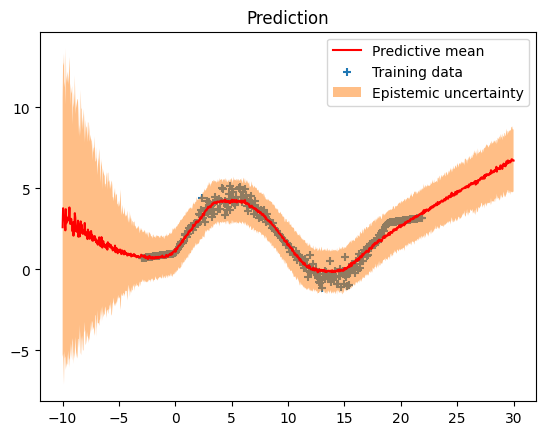

In [8]:
X_test = np.linspace(-10, 30, 1000).reshape(-1, 1)
y_pred_list = []

for i in tqdm(range(200)):
    y_pred = model_vi.predict(X_test, verbose=0)
    y_pred_list.append(y_pred)
    
y_preds = np.concatenate(y_pred_list, axis=1)

y_mean = np.mean(y_preds, axis=1)
y_sigma = np.std(y_preds, axis=1)

plt.plot(X_test, y_mean, 'r-', label='Predictive mean');
plt.scatter(x=x,y=y, marker='+', label='Training data')
plt.fill_between(X_test.ravel(), 
                 y_mean + 2 * y_sigma, 
                 y_mean - 2 * y_sigma, 
                 alpha=0.5, label='Epistemic uncertainty')
plt.title('Prediction')
plt.legend()

In [11]:
model_vi.weights

[<tf.Variable 'dense_flipout/kernel_posterior_loc:0' shape=(1, 20) dtype=float32, numpy=
 array([[-0.15594876, -0.11701068, -0.16896662, -0.189393  , -0.17857146,
         -0.1523693 , -0.16593175, -0.17932174, -0.12877874, -0.15122135,
          0.21299702, -0.00548413, -0.18685582, -0.17762946, -0.0934274 ,
         -0.18718019, -0.12144522, -0.19678336, -0.24665993, -0.13734382]],
       dtype=float32)>,
 <tf.Variable 'dense_flipout/kernel_posterior_untransformed_scale:0' shape=(1, 20) dtype=float32, numpy=
 array([[-2.858241 , -3.0853906, -3.1610801, -2.6101902, -2.6295133,
         -2.7449872, -2.7800124, -2.6570442, -3.0351923, -2.8068275,
         -5.7839518, -4.140505 , -4.1560006, -2.6412125, -3.2591498,
         -2.697031 , -3.0126734, -2.522681 , -2.415645 , -2.7706258]],
       dtype=float32)>,
 <tf.Variable 'dense_flipout/bias_posterior_loc:0' shape=(20,) dtype=float32, numpy=
 array([-0.52508366, -0.30516413,  0.19571765, -0.66824114, -0.71642256,
        -0.74392605, -0.